In [3]:
# Read in data from Heroku API and put into Pandas Dataframe
import pandas as pd
import json, requests
url = "http://magic-stocks.herokuapp.com/api/v1/metrics/usb"
response = requests.get(url).json()
df = pd.DataFrame(response)
df.head()

OSError: [WinError 193] %1 is not a valid Win32 application

In [6]:
# Import plotting tools
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from sklearn import preprocessing

OSError: [WinError 193] %1 is not a valid Win32 application

In [3]:
# Number of Historical Days used to Analyze next Closing Price
history_points = 50

# Remove date and ticker columns
del df['date']
del df['ticker']
del df['adj_close']
del df['direction']
del df['dividend']
del df['id']
del df['roc']
del df['rsi']
del df['slowd']
del df['slowk']
del df['sma']
del df['split']
del df['std']
del df['willr']
del df['next_close']

In [4]:
df = df[['open_amt', 'high', 'low', 'close', 'volume']]

In [5]:
# Scale the data
data_normaliser = preprocessing.MinMaxScaler()
data_normalised = data_normaliser.fit_transform(df)

In [6]:
# using the last {history_points} open high low close volume data points, predict the next open value
ohlcv_histories_normalised = np.array([data_normalised[i  : i + history_points].copy() for i in range(len(data_normalised) - history_points)])
next_day_open_values_normalised = np.array([data_normalised[:,0][i + history_points].copy() for i in range(len(data_normalised) - history_points)])
next_day_open_values_normalised = np.expand_dims(next_day_open_values_normalised, -1)

next_day_open_values = np.array([df.iloc[:,0][i + history_points].copy() for i in range(len(df) - history_points)])
next_day_open_values = np.expand_dims(next_day_open_values, -1)

y_normaliser = preprocessing.MinMaxScaler()
y_normaliser.fit(next_day_open_values)

MinMaxScaler(copy=True, feature_range=(0, 1))

In [13]:
ohlcv_histories = df
unscaled_y = next_day_open_values.copy()

test_split = 0.9 # the percent of data to be used for testing
n = int(ohlcv_histories.shape[0] * test_split)

# splitting the dataset up into train and test sets

ohlcv_train = ohlcv_histories[:n]
y_train = next_day_open_values[:n]

ohlcv_test = ohlcv_histories[n:]
y_test = next_day_open_values[n:]

unscaled_y_test = unscaled_y[n:]

In [16]:
import keras
import tensorflow as tf
from keras.models import Model
from keras.layers import Dense, Dropout, LSTM, Input, Activation, concatenate
from keras import optimizers
np.random.seed(4)
from tensorflow import set_random_seed
set_random_seed(4)

lstm_input = Input(shape=(history_points, 5), name='lstm_input')
x = LSTM(50, name='lstm_0')(lstm_input)
x = Dropout(0.2, name='lstm_dropout_0')(x)
x = Dense(64, name='dense_0')(x)
x = Activation('sigmoid', name='sigmoid_0')(x)
x = Dense(1, name='dense_1')(x)
output = Activation('linear', name='linear_output')(x)
model = Model(inputs=lstm_input, outputs=output)

adam = optimizers.Adam(lr=0.0005)

model.compile(optimizer=adam, loss='mse')

from keras.utils import plot_model
plot_model(model, to_file='model.png')

ImportError: Keras requires TensorFlow 2.2 or higher. Install TensorFlow via `pip install tensorflow`

In [17]:
!pip install --user tensorflow

  Could not find a version that satisfies the requirement tensorflow (from versions: )
No matching distribution found for tensorflow
You are using pip version 19.0.3, however version 20.2b1 is available.
You should consider upgrading via the 'python -m pip install --upgrade pip' command.


In [12]:
model.fit(x=ohlcv_train, y=y_train, batch_size=32, epochs=50, shuffle=True, validation_split=0.1)
evaluation = model.evaluate(ohlcv_test, y_test)
print(evaluation)

,open_amt,high,low,close,volume
0,23.23,23.94,23.06,23.91,12243200
1,23.82,23.89,23.52,23.77,7028200
2,24.03,24.56,24.02,24.43,11937400
3,24.33,24.35,23.94,24.14,10744000
4,24.25,24.48,23.67,24.40,14224200


In [83]:
y_test_predicted = model.predict(ohlcv_test)
# model.predict returns normalised values
# now we scale them back up using the y_scaler from before
y_test_predicted = y_scaler.inverse_transform(y_test_predicted)

# also getting predictions for the entire dataset, just to see how it performs
y_predicted = model.predict(ohlcv_histories)
y_predicted = y_scaler.inverse_transform(y_predicted)

assert unscaled_y_test.shape == y_test_predicted.shape
real_mse = np.mean(np.square(unscaled_y_test - y_test_predicted))
scaled_mse = real_mse / (np.max(unscaled_y_test) - np.min(unscaled_y_test)) * 100
print(scaled_mse)

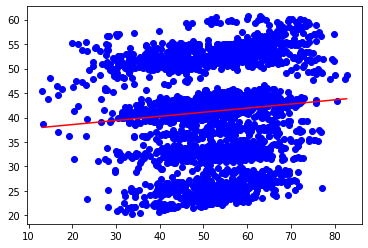

In [84]:
plt.gcf().set_size_inches(22, 15, forward=True)

start = 0
end = -1

real = plt.plot(unscaled_y_test[start:end], label='real')
pred = plt.plot(y_test_predicted[start:end], label='predicted')

plt.legend(['Real', 'Predicted'])

plt.show()

In [85]:
# Quantifying a Linear Regression Model
predicted = model.predict(X)

In [86]:
## Mean Squared Error (MSE) Closer to 0 is good, further from 0 is bad
from sklearn.metrics import mean_squared_error
mse = mean_squared_error(y, predicted)

In [87]:
## R2 Score (R-Squared) Closer to 1 is good, closer to 0 is bad
from sklearn.metrics import r2_score
r2 = r2_score(y, predicted)

In [88]:
## OR
model.score(X, y)

0.008541097574489509

In [89]:
# Testing and Training data using Sklearn
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

model.fit(X_train, y_train)
model.score(X_test, y_test)

0.0074031480412080075